In [46]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import numpy as np
#import cv2
framerate = 29.18
from scipy import signal
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
#%cd "D:\Interfacial Waves resonance videos 0430"

In [115]:
vidcap = cv2.VideoCapture('reverseRamp.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("reverseRamp/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

In [3]:
vidcap = cv2.VideoCapture('reference.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("reference/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

### Loading frozen frequencies

In [2]:
frozenFreqs = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/frequencies.txt')
noRampVids = ['06V', '07V', '075V', '08V', '085V', '09V', '1V' , '11V', '12V', '125V', '13V', '135V', '14V', '145V', '15V']

Resonance = []
for v in noRampVids:
    plt.clf()
    ampl = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/movingAvg/%s.txt' %v)
    width = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/movingAvg/%sWidth.txt' %v)
    Resonance.append([np.max(ampl), np.max(width)])
Resonance = np.array(Resonance)

<Figure size 432x288 with 0 Axes>

In [3]:
surfaceResonance = []
for v in noRampVids:
    plt.clf()
    n = 10
    ampl = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/timeseries/surfaceresponse/%s' %v, skiprows=2)
    amplM = np.convolve(ampl[:,1], np.ones((n,))/n, mode='same')
    surfaceResonance.append([np.max(amplM)])
surfaceResonance = np.array(surfaceResonance)

<Figure size 432x288 with 0 Axes>

### Reference

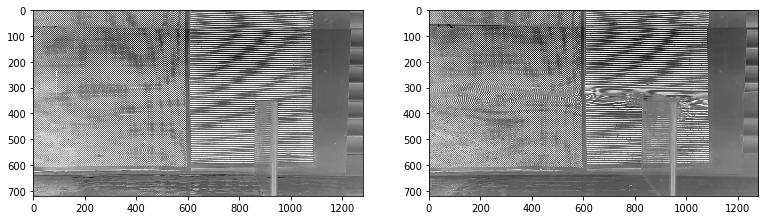

In [42]:
import numpy as np
import matplotlib.pyplot as plt

water = cv2.flip(cv2.imread("reference/frame200.jpg", cv2.IMREAD_GRAYSCALE), -1)
img = cv2.flip(cv2.imread("mediumRamp/frame1500.jpg", cv2.IMREAD_GRAYSCALE), -1)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,8))

cv2.equalizeHist(water)
cv2.equalizeHist(img)
ax1.imshow(water, cmap='Greys')
ax2.imshow(img, cmap='Greys')
plt.show()


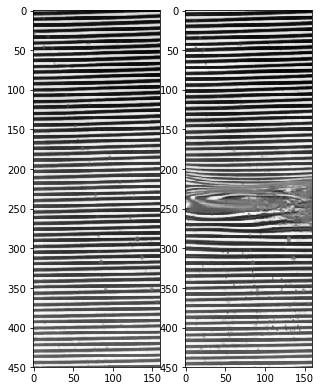

In [43]:
imgcut = img[100:550, 640:800]
refcut = water[100:550, 640:800]
f, (ax1, ax2) = plt.subplots(1,2, figsize=(5,13))
ax1.imshow(refcut, cmap='Greys')
ax2.imshow(imgcut, cmap='Greys')
refref = refcut[:, 75]
imgref = imgcut[:, 75]


(450,)
(450, 160)


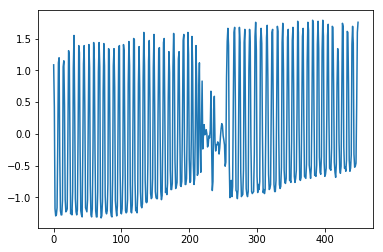

In [44]:

print(refref.shape)
print(refcut.shape)
#plt.plot(normalize(255. - refref))
plt.plot(normalize(255. - imgref))

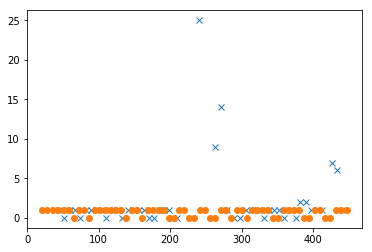

In [33]:


peaksimg, _ = find_peaks(normalize(255.-imgref), height=1.25)
peaks, _ = find_peaks(normalize(255.-refref), height=0.9)

plt.plot(peaksimg[2:], np.abs(np.diff(np.diff(peaksimg))), "x")
plt.plot(peaks[2:], np.abs(np.diff(np.diff(peaks))), "o")

In [4]:
def read_file(src):
    img = cv2.flip(cv2.imread(src, cv2.IMREAD_GRAYSCALE), -1)
    return img

def printMaxAmpl(img, ref, col, loc):
    #img = img[120:515, loc[0]:loc[1]]
    #ref = ref[180:550, 600:700]
    #cv2.equalizeHist(img)
    #return locateInterface(img, maxplace, col)
    
    img = img[100:550, loc[0]:loc[1]]
    #ref = ref[180:550, 600:700]
    cv2.equalizeHist(img)

    cv2.equalizeHist(ref)
    imgref = img[:,col]
    refref = ref[:,col]
    peaksimg, _ = find_peaks(normalize(255.-imgref), height=1.25)
    peaks, _ = find_peaks(normalize(255.-refref), height=0.9)

    shorter =  np.min([len(peaksimg), len(peaks)])
    peaksimgcut = peaksimg
    peakscut = peaks[:shorter]
    maxplace = np.argmax(np.abs(np.diff(np.diff(peaksimgcut))))
    place = peaksimg[1:][maxplace]
    width = np.max(np.abs(np.diff(np.diff(peaksimgcut))))
    return [place, width]


def filterOnce(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)

    divs = np.abs(original-avg)> 2.5*std
    index = np.arange(0, len(original), 1)
    filtered[index[divs]] = filtered[index[divs]-1]
    #print(np.sum(divs))
    return filtered

def filterUntilSmooth(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)
    div = np.abs(original-avg) > 2.5*std
    while(np.sum(div)>0):
        filtered = filterOnce(filtered)
        avg = np.average(filtered)
        std = np.std(filtered)
        div = np.abs(filtered-avg)>2.5*std
    return filtered

def normalize(timeseries):
    avg = np.average(timeseries)
    stdev = np.std(np.abs(timeseries))
    return (timeseries-avg)/stdev

In [5]:
import os
def measureInterface(src):
    ls = os.listdir(src) # list
    numberOfFiles = len(ls)
    refc =refcut

    ampls = []
    for i in range(numberOfFiles):
        #print(i)
        img = read_file("%s/frame%s.jpg" %(src,i))
        amplsincol = []
        ampls.append(printMaxAmpl(img, refc,75, [640, 800]))
    return np.array(ampls)

In [48]:
mediumRamp = measureInterface("mediumRamp")

In [116]:
reverseRamp = measureInterface("reverseRamp")

In [69]:
np.savetxt("MediumRamp.dat", mediumRamp)

In [122]:
np.savetxt("reverseRamp.dat", reverseRamp)

In [8]:
mediumRamp = np.loadtxt('data0430/MediumRamp.dat')
reverseRamp = np.loadtxt('data0430/reverseRamp.dat')

(2000, 3000)

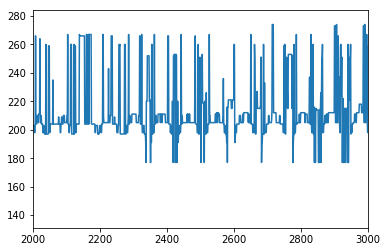

In [9]:
plt.plot(filterUntilSmooth(reverseRamp[:,0][500:]))
plt.xlim(2000, 3000)

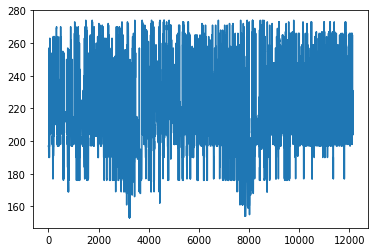

In [10]:
plt.plot(filterUntilSmooth(mediumRamp[:,0][500:]))


In [50]:
framerate = 29.18
windowlength = 20.*framerate ## 30 sec
indeces = np.arange(0, len(mediumRamp), 1)
startpoints = np.arange(0, len(mediumRamp)-int(windowlength), int(windowlength))
endpoints = np.arange(int(windowlength), len(mediumRamp), int(windowlength))


In [63]:
filteredRamp = np.empty_like(mediumRamp)

In [64]:
filteredRamp[:,1] = mediumRamp[:,1]

In [65]:
for i in range(len(startpoints)):
    print(endpoints[i])
    filteredRamp[:,0][startpoints[i] : endpoints[i]] = filterUntilSmooth(mediumRamp[:,0][startpoints[i] : endpoints[i]])

583
1166
1749
2332
2915
3498
4081
4664
5247
5830
6413
6996
7579
8162
8745
9328
9911
10494
11077
11660
12243


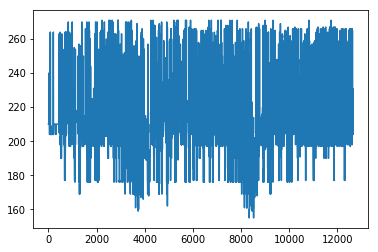

In [68]:
plt.plot(filterUntilSmooth(mediumRamp[:,0]))

### Surface and driving

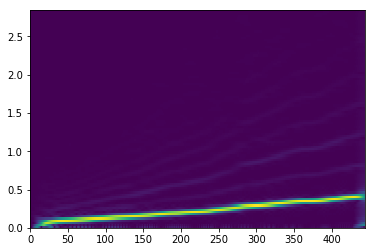

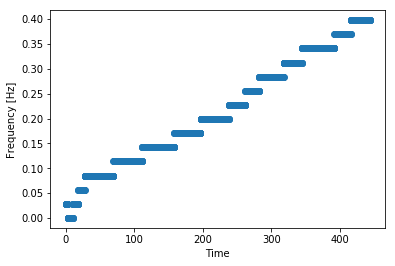

In [11]:
driving = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/driving/mediumRamp', skiprows=2)
surface = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/surfaceresponse/mediumRamp', skiprows=2)
fr = 1/(driving[1,0]-driving[0,0]) ##framerate
from scipy import signal

f, t, Zxx = signal.stft(driving[:,1], fr, nperseg=200,noverlap=199, detrend='constant')
plt.pcolormesh(t, f, np.abs(Zxx))
plt.show()
plt.plot(t, f[np.argmax(np.abs(Zxx), axis=0)], 'o')
frequencies = f[np.argmax(np.abs(Zxx), axis=0)]
plt.xlabel('Time')
plt.ylabel('Frequency [Hz]')

plt.show()

In [12]:
times_cut = t[t>50]
frequencies_cut = frequencies[t>50]

In [13]:
from scipy.optimize import curve_fit
def lin(x, a,b):
    return x*a+b

popt, pcov = curve_fit(lin, times_cut, frequencies_cut)

Text(0, 0.5, 'Frequency [Hz]')

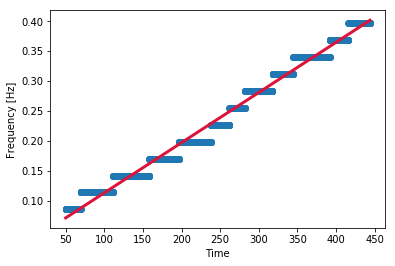

In [15]:
plt.plot(times_cut, frequencies_cut, 'o')
plt.plot(times_cut, lin(times_cut, *popt), '-', linewidth = 3., c='Crimson')
plt.xlabel('Time')
plt.ylabel('Frequency [Hz]')

In [119]:
movingAvgIFasdasd = np.convolve(reverseRamp[:,0], np.ones((N,))/N, mode='same')


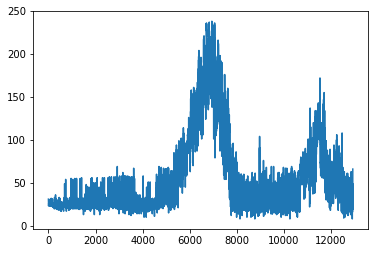

In [16]:
N = int(20*29.18)
movingAvgIF = np.convolve(mediumRamp[:,0], np.ones((N,))/N, mode='same')
movingAvgIFw = np.convolve(mediumRamp[:,1], np.ones((N,))/N, mode='same')
#movingAvgsurface = np.convolve(rightside, np.ones((N,))/N, mode='same')

#surfaceTracker = surface[surface[:,0]>50]
movingAvgsurfaceTracker = np.convolve(surface[:,1], np.ones((N,))/N, mode='same')[np.logical_and(surface[:,0]>120, surface[:,0]<350)]
timeSurface = surface[np.logical_and(surface[:,0]>120, surface[:,0]<350)][:,0]


In [17]:
tFine = np.arange(0., len(mediumRamp), 1)/29.18
tFineFiltered = tFine[tFine>50]

movingAvgIF_filt = movingAvgIF[tFine>50]
movingAvgIFw_filt = movingAvgIFw[tFine>50]
#movingAvgsurface_filt = movingAvgsurfaceTracker[tFine>50]


#plt.plot(tFineFiltered, movingAvgIF_filt, 'o', markersize=1.)
tSelected = tFineFiltered[np.logical_and(tFineFiltered<350, tFineFiltered>120)]
movIFFiltered = movingAvgIF_filt[np.logical_and(tFineFiltered<350, tFineFiltered>120)]
movIFFilteredw = movingAvgIFw_filt[np.logical_and(tFineFiltered<350, tFineFiltered>120)]

## Increasing frequency

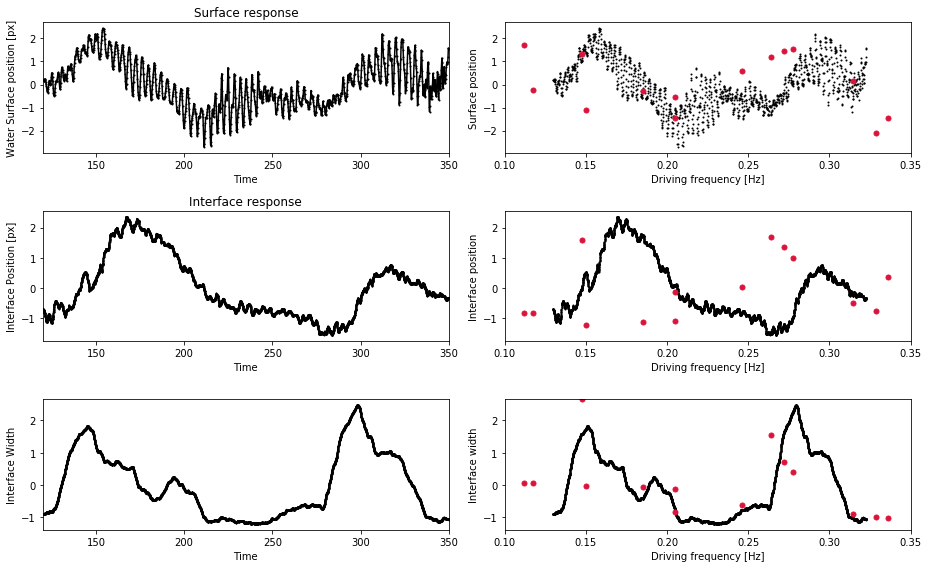

In [20]:
f, axes = plt.subplots(3, 2)
for i in range(3):
    axes[i][0].set_xlim(120, 350)
    
for i in range(3):
    axes[i][1].set_xlim(0.1, 0.35)
axes[0][0].plot(timeSurface, normalize(movingAvgsurfaceTracker), '-o', markersize=1, c='black')
axes[0][0].set_xlabel('Time')
axes[0][0].set_ylabel('Water Surface position [px]')
axes[0][0].set_title('Surface response')

axes[1][0].plot(tSelected, normalize(movIFFiltered),'-o', markersize=1, c='black')
axes[1][0].set_xlabel('Time')
axes[1][0].set_ylabel('Interface Position [px]')
axes[1][0].set_title('Interface response')

axes[0][1].plot(lin(timeSurface, *popt),  normalize(movingAvgsurfaceTracker), 'o', markersize=1, c='black')
#axes[0][1].plot(frequencies, normalize(surfaceRes[:,1]), 'o', markersize=5, c='Crimson')
axes[0][1].set_ylabel('Surface position')
axes[0][1].set_xlabel('Driving frequency [Hz]')
axes[0][1].plot(frozenFreqs, normalize(surfaceResonance), 'o', markersize=5, c='Crimson')
axes[0][1].set_ylim(axes[0][0].get_ylim())

#axes[0][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
#axes[0][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')
#axes[0][1].legend(loc='upper left')

axes[1][1].plot(lin(tSelected, *popt),  normalize(movIFFiltered), 'o', markersize=1, c='black')
axes[1][1].plot(frozenFreqs, normalize(Resonance[:,0]), 'o', markersize=5, c='Crimson')
axes[1][1].set_ylim(axes[1][0].get_ylim())
#axes[1][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
#axes[1][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')

axes[1][1].set_ylabel('Interface position')
axes[1][1].set_xlabel('Driving frequency [Hz]')


axes[2][0].plot(tSelected, normalize(movIFFilteredw),'-o', markersize=1, c='black')
axes[2][0].set_ylabel('Interface Width')
axes[2][0].set_xlabel('Time')

axes[2][1].plot(lin(tSelected, *popt),  normalize(movIFFilteredw), 'o', markersize=1, c='black')
axes[2][1].plot(frozenFreqs, normalize(Resonance[:,1]), 'o', markersize=5, c='Crimson')

axes[2][1].set_ylim(axes[2][0].get_ylim())
#axes[2][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
#axes[2][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')


axes[2][1].set_ylabel('Interface width')
axes[2][1].set_xlabel('Driving frequency [Hz]')


f.set_size_inches((13, 8))
f.tight_layout()

In [21]:
tSelected = tFineFiltered[np.logical_and(tFineFiltered<350, tFineFiltered>120)]
movIFFiltered = movingAvgIF_filt[np.logical_and(tFineFiltered<350, tFineFiltered>120)]
movIFFilteredw = movingAvgIFw_filt[np.logical_and(tFineFiltered<350, tFineFiltered>120)]

## Reverse Ramp

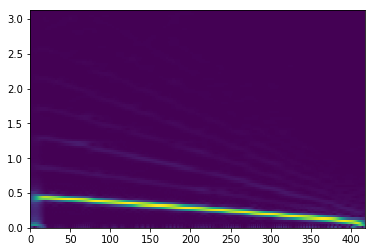

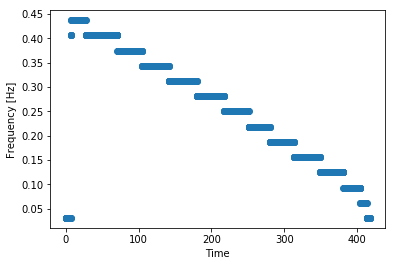

In [26]:
driving = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/driving/reverseRamp', skiprows=2)
surface = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/surfaceresponse/reverseRamp', skiprows=2)
fr = 1/(driving[1,0]-driving[0,0]) ##framerate
from scipy import signal

frr, tr, Zxxr = signal.stft(driving[:,1], fr, nperseg=200,noverlap=199, detrend='constant')
plt.pcolormesh(tr, frr, np.abs(Zxxr))
plt.show()
plt.plot(tr, frr[np.argmax(np.abs(Zxxr), axis=0)], 'o')
frequencies = frr[np.argmax(np.abs(Zxxr), axis=0)]
plt.xlabel('Time')
plt.ylabel('Frequency [Hz]')

plt.show()

In [27]:
times_cutr = tr[tr>50]
frequencies_cutr = frequencies[tr>50]

In [28]:
from scipy.optimize import curve_fit
def lin(x, a,b):
    return x*a+b

poptr, pcovr = curve_fit(lin, times_cutr, frequencies_cutr)

Text(0, 0.5, 'Frequency [Hz]')

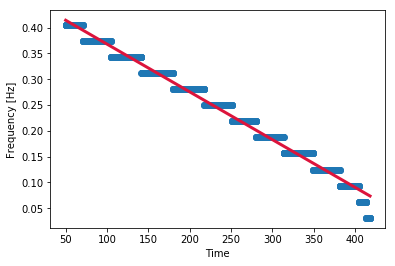

In [29]:
plt.plot(times_cutr, frequencies_cutr, 'o')
plt.plot(times_cutr, lin(times_cutr, *poptr), '-', linewidth = 3., c='Crimson')
plt.xlabel('Time')
plt.ylabel('Frequency [Hz]')

In [31]:
N = int(20*29.18)
movingAvgIFr = np.convolve(filterUntilSmooth(reverseRamp[:,0]), np.ones((N,))/N, mode='same')
movingAvgIFwr = np.convolve(reverseRamp[:,1], np.ones((N,))/N, mode='same')
#movingAvgsurface = np.convolve(rightside, np.ones((N,))/N, mode='same')

#surfaceTracker = surface[surface[:,0]>50]
movingAvgsurfaceTrackerr = np.convolve(surface[:,1], np.ones((N,))/N, mode='same')[np.logical_and(surface[:,0]>20, surface[:,0]<400)]
timeSurfacer = surface[np.logical_and(surface[:,0]>20, surface[:,0]<400)][:,0]
tFiner = np.arange(0., len(reverseRamp), 1)/29.18
tFineFilteredr = tFiner[tFiner>20]

movingAvgIF_filtr = movingAvgIFr[tFiner>20]
movingAvgIFw_filtr = movingAvgIFwr[tFiner>20]
#movingAvgsurface_filt = movingAvgsurfaceTracker[tFine>50]


#plt.plot(tFineFiltered, movingAvgIF_filt, 'o', markersize=1.)
tSelectedr = tFineFilteredr[np.logical_and(tFineFilteredr<400, tFineFilteredr>20)]
movIFFilteredr = movingAvgIF_filtr[np.logical_and(tFineFilteredr<400, tFineFilteredr>20)]
movIFFilteredwr = movingAvgIFw_filtr[np.logical_and(tFineFilteredr<400, tFineFilteredr>20)]

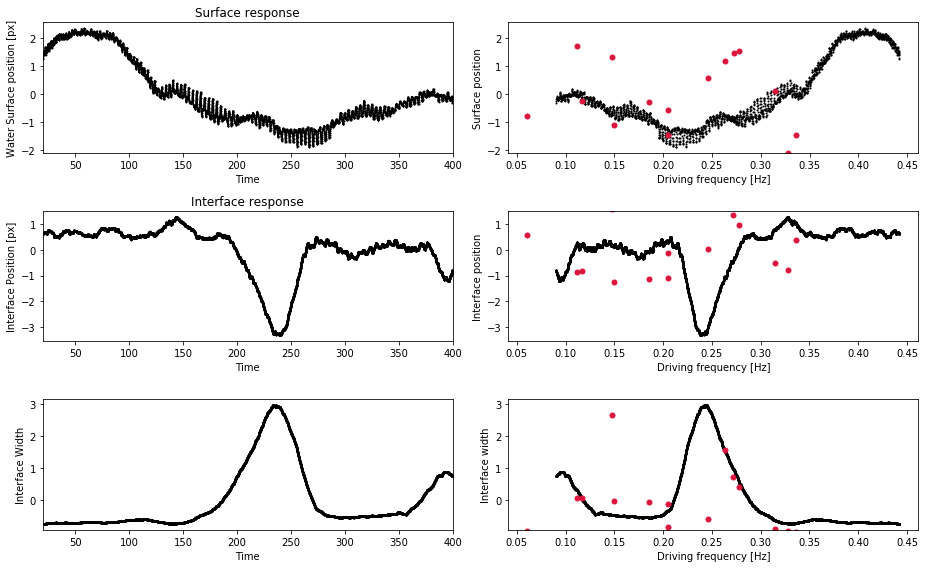

In [33]:
f, axes = plt.subplots(3, 2)
for i in range(3):
    axes[i][0].set_xlim(20, 400)
    
#for i in range(3):
#    axes[i][1].set_xlim(0.1, 0.35)
axes[0][0].plot(timeSurfacer, normalize(movingAvgsurfaceTrackerr), '-o', markersize=1, c='black')
axes[0][0].set_xlabel('Time')
axes[0][0].set_ylabel('Water Surface position [px]')
axes[0][0].set_title('Surface response')

axes[1][0].plot(tSelectedr, normalize(movIFFilteredr),'-o', markersize=1, c='black')
axes[1][0].set_xlabel('Time')
axes[1][0].set_ylabel('Interface Position [px]')
axes[1][0].set_title('Interface response')

axes[0][1].plot(lin(timeSurfacer, *poptr),  normalize(movingAvgsurfaceTrackerr), 'o', markersize=1, c='black')
#axes[0][1].plot(frequencies, normalize(surfaceRes[:,1]), 'o', markersize=5, c='Crimson')
axes[0][1].set_ylabel('Surface position')
axes[0][1].set_xlabel('Driving frequency [Hz]')
axes[0][1].plot(frozenFreqs, normalize(surfaceResonance), 'o', markersize=5, c='Crimson')
axes[0][1].set_ylim(axes[0][0].get_ylim())

#axes[0][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
#axes[0][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')
#axes[0][1].legend(loc='upper left')

axes[1][1].plot(lin(tSelectedr, *poptr),  normalize(movIFFilteredr), 'o', markersize=1, c='black')
axes[1][1].plot(frozenFreqs, normalize(Resonance[:,0]), 'o', markersize=5, c='Crimson')
axes[1][1].set_ylim(axes[1][0].get_ylim())
#axes[1][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
#axes[1][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')

axes[1][1].set_ylabel('Interface position')
axes[1][1].set_xlabel('Driving frequency [Hz]')


axes[2][0].plot(tSelectedr, normalize(movIFFilteredwr),'-o', markersize=1, c='black')
axes[2][0].set_ylabel('Interface Width')
axes[2][0].set_xlabel('Time')

axes[2][1].plot(lin(tSelectedr, *poptr),  normalize(movIFFilteredwr), 'o', markersize=1, c='black')
axes[2][1].plot(frozenFreqs, normalize(Resonance[:,1]), 'o', markersize=5, c='Crimson')

axes[2][1].set_ylim(axes[2][0].get_ylim())
#axes[2][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
#axes[2][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')


axes[2][1].set_ylabel('Interface width')
axes[2][1].set_xlabel('Driving frequency [Hz]')


f.set_size_inches((13, 8))
f.tight_layout()

In [45]:
print(popt)
print(poptr)

[0.0008393  0.02904187]
[-0.0009265   0.46084276]


## Ramps in opposite direction:

### Red: increasing frequency, $F(t) = 0.029 + 0.00084 \cdot t$
### Black: decreasing frequency, $F(t) = 0.46 - 0.00092 \cdot t$



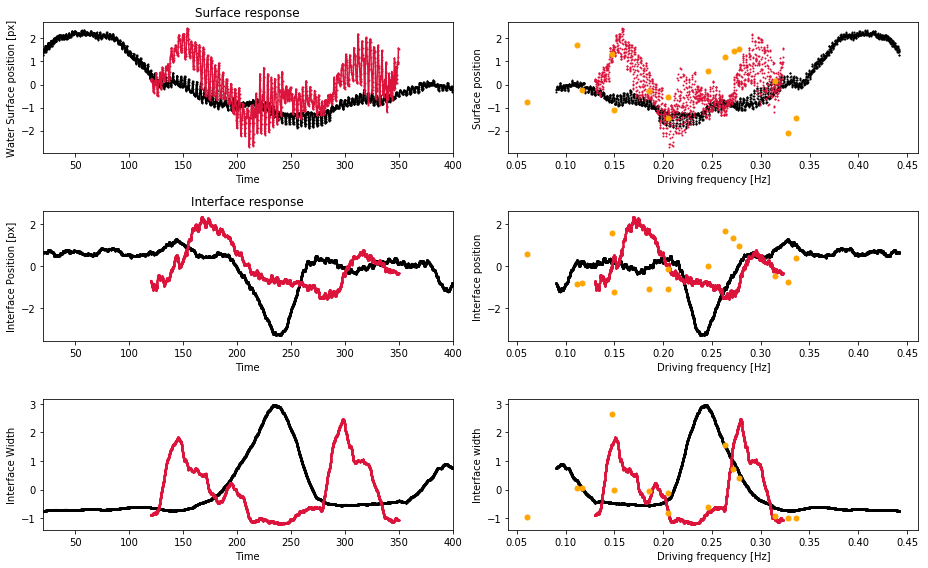

In [44]:
f, axes = plt.subplots(3, 2)
for i in range(3):
    axes[i][0].set_xlim(20, 400)
    
#for i in range(3):
#    axes[i][1].set_xlim(0.1, 0.35)
axes[0][0].plot(timeSurfacer, normalize(movingAvgsurfaceTrackerr), '-o', markersize=1, c='black')
axes[0][0].plot(timeSurface, normalize(movingAvgsurfaceTracker), '-o', markersize=1, c='Crimson')

axes[0][0].set_xlabel('Time')
axes[0][0].set_ylabel('Water Surface position [px]')
axes[0][0].set_title('Surface response')

axes[1][0].plot(tSelectedr, normalize(movIFFilteredr),'-o', markersize=1, c='black')
axes[1][0].plot(tSelected, normalize(movIFFiltered),'-o', markersize=1, c='Crimson')
axes[1][0].set_xlabel('Time')
axes[1][0].set_ylabel('Interface Position [px]')
axes[1][0].set_title('Interface response')

axes[0][1].plot(lin(timeSurfacer, *poptr),  normalize(movingAvgsurfaceTrackerr), 'o', markersize=1, c='black')
axes[0][1].plot(lin(timeSurface, *popt),  normalize(movingAvgsurfaceTracker), 'o', markersize=1, c='Crimson')

#axes[0][1].plot(frequencies, normalize(surfaceRes[:,1]), 'o', markersize=5, c='Crimson')
axes[0][1].set_ylabel('Surface position')
axes[0][1].set_xlabel('Driving frequency [Hz]')
axes[0][1].plot(frozenFreqs, normalize(surfaceResonance), 'o', markersize=5, c='Orange')
axes[0][1].set_ylim(axes[0][0].get_ylim())

#axes[0][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
#axes[0][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')
#axes[0][1].legend(loc='upper left')

axes[1][1].plot(lin(tSelectedr, *poptr),  normalize(movIFFilteredr), 'o', markersize=1, c='black')
axes[1][1].plot(lin(tSelected, *popt),  normalize(movIFFiltered), 'o', markersize=1, c='Crimson')

axes[1][1].plot(frozenFreqs, normalize(Resonance[:,0]), 'o', markersize=5, c='Orange')
axes[1][1].set_ylim(axes[1][0].get_ylim())
#axes[1][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
#axes[1][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')

axes[1][1].set_ylabel('Interface position')
axes[1][1].set_xlabel('Driving frequency [Hz]')


axes[2][0].plot(tSelectedr, normalize(movIFFilteredwr),'-o', markersize=1, c='black')
axes[2][0].plot(tSelected, normalize(movIFFilteredw),'-o', markersize=1, c='Crimson')

axes[2][0].set_ylabel('Interface Width')
axes[2][0].set_xlabel('Time')

axes[2][1].plot(lin(tSelectedr, *poptr),  normalize(movIFFilteredwr), 'o', markersize=1, c='black')
axes[2][1].plot(lin(tSelected, *popt),  normalize(movIFFilteredw), 'o', markersize=1, c='Crimson')

axes[2][1].plot(frozenFreqs, normalize(Resonance[:,1]), 'o', markersize=5, c='Orange')

axes[2][1].set_ylim(axes[2][0].get_ylim())
#axes[2][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
#axes[2][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')


axes[2][1].set_ylabel('Interface width')
axes[2][1].set_xlabel('Driving frequency [Hz]')


f.set_size_inches((13, 8))
f.tight_layout()